<a href="https://colab.research.google.com/github/yRavi21/Sentiment-analysis/blob/Whatsapp-Sentiment-Analysis/sentiment_analysis_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize

In [ ]:
pip install emoji

In [ ]:
conversation_file = 'WhatsApp Chat with Unofficial Group BHU.txt'

def load_whatsapp_data(file_path):
    with open(file_path, encoding='utf-8') as file:
        lines = file.readlines()

    data = []
    message_buffer = []
    date, time, author = None, None, None

    for line in lines:
        line = line.strip()
        if date_time(line):
            if message_buffer:
                data.append([date, time, author, ' '.join(message_buffer)])
                message_buffer.clear()
            date, time, author, message = get_datapoint(line)
            message_buffer.append(message)
        else:
            message_buffer.append(line)

    return pd.DataFrame(data, columns=["Date", 'Time', 'Author', 'Message'])

def date_time(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

def get_datapoint(line):
    splitline = line.split(' - ')
    dateTime = splitline[0]
    date, time = dateTime.split(", ")
    message = " ".join(splitline[1:])
    if find_author(message):
        splitmessage = message.split(": ")
        author = splitmessage[0]
        message = " ".join(splitmessage[1:])
    else:
        author= None
    return date, time, author, message

def find_author(s):
    s = s.split(":")
    if len(s) == 2:
        return True
    else:
        return False

In [ ]:
whatsapp_data = load_whatsapp_data(conversation_file)

In [ ]:
whatsapp_data

,Date,Time,Author,Message
0,24/11/22,12:28,None,Messages and calls are end-to-end encrypted. N...
1,20/11/22,09:07,None,"Himanshu BHU created group ""BHU M.Sc. CSA Unof..."
2,24/11/22,12:27,None,You joined using this group's invite link
3,24/11/22,12:31,Himanshu BHU,@918271732745 yha puch le bhai
4,24/11/22,12:32,Nitesh,"I am here , thanks"
...,...,...,...,...
24066,29/12/23,16:14,Kajal BHU,"Okay, aaj 3 baje start hua tha?"
24067,29/12/23,16:14,Vaibhav BHU,Yup
24068,29/12/23,16:14,Kajal BHU,"Acha,meeting start krne tym dono din ,app se n..."
24069,29/12/23,16:30,Vaibhav BHU,They're eagerly waiting for everyone's present...


In [ ]:
data = whatsapp_data
df = pd.DataFrame(data, columns=["Date", 'Time', 'Author', 'Message'])
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df = df.dropna()
data = df.copy()
data.head()

,Date,Time,Author,Message
3,2022-11-24,12:31,Himanshu BHU,@918271732745 yha puch le bhai
4,2022-11-24,12:32,Nitesh,"I am here , thanks"
5,2022-11-24,12:48,Gourav Jinagal BHU,Acha
6,2022-11-24,13:08,+91 84820 02929,149 lao bhar-pet kathi kabar aur kuche dabake jao
7,2022-11-24,13:08,+91 84820 02929,*kabab


In [ ]:
def remove_pattern(text,pattern):
    r = re.findall(pattern,text)
    for i in r:
        text = re.sub(i,"",text)
    return text
data['Tidy_Message'] = np.vectorize(remove_pattern)(data['Message'], "@[\w]*")
data['Tidy_Message'] = data['Tidy_Message'].str.replace("[^a-zA-Z#]", " ",regex = True)
data.head(10)


,Date,Time,Author,Message,Tidy_Message
3,2022-11-24,12:31,Himanshu BHU,@918271732745 yha puch le bhai,yha puch le bhai
4,2022-11-24,12:32,Nitesh,"I am here , thanks",I am here thanks
5,2022-11-24,12:48,Gourav Jinagal BHU,Acha,Acha
6,2022-11-24,13:08,+91 84820 02929,149 lao bhar-pet kathi kabar aur kuche dabake jao,lao bhar pet kathi kabar aur kuche dabake jao
7,2022-11-24,13:08,+91 84820 02929,*kabab,kabab
8,2022-11-24,13:14,Vaibhav BHU,"Kisi ko kuch puchtaach karwani h to batate de,...",Kisi ko kuch puchtaach karwani h to batate de ...
9,2022-11-24,13:16,+91 84820 02929,book list le aa bhai,book list le aa bhai
10,2022-11-24,13:16,+91 84820 02929,suggestion of bole books,suggestion of bole books
11,2022-11-24,13:17,Yash,Haan computer lab ki photo bhejna,Haan computer lab ki photo bhejna
12,2022-11-24,13:24,Venkatesh BHU,Passbook mil rha ya nhi?,Passbook mil rha ya nhi


In [ ]:
#Tokenization
tokenized_Message = data['Tidy_Message'].apply(lambda x: x.split())
tokenized_Message.head()

3                                [yha, puch, le, bhai]
4                                [I, am, here, thanks]
5                                               [Acha]
6    [lao, bhar, pet, kathi, kabar, aur, kuche, dab...
7                                              [kabab]
Name: Tidy_Message, dtype: object

In [ ]:
# Stemming
from nltk import PorterStemmer
ps = PorterStemmer()
tokenized_Message = tokenized_Message.apply(lambda x: [ps.stem(i) for i in x])
tokenized_Message.head()

3                                [yha, puch, le, bhai]
4                                 [i, am, here, thank]
5                                               [acha]
6    [lao, bhar, pet, kathi, kabar, aur, kuch, daba...
7                                              [kabab]
Name: Tidy_Message, dtype: object

In [ ]:
data['Tidy_Message'] = [' '.join(tokens) for tokens in tokenized_Message]
data.head()

,Date,Time,Author,Message,Tidy_Message
3,2022-11-24,12:31,Himanshu BHU,@918271732745 yha puch le bhai,yha puch le bhai
4,2022-11-24,12:32,Nitesh,"I am here , thanks",i am here thank
5,2022-11-24,12:48,Gourav Jinagal BHU,Acha,acha
6,2022-11-24,13:08,+91 84820 02929,149 lao bhar-pet kathi kabar aur kuche dabake jao,lao bhar pet kathi kabar aur kuch dabak jao
7,2022-11-24,13:08,+91 84820 02929,*kabab,kabab


In [ ]:
pip install googletrans==4.0.0-rc1

In [ ]:
data['Tidy_Message_String'] = data['Tidy_Message'].apply(lambda x: ''.join(x))

In [ ]:
det = data.head(1000)
det

,Date,Time,Author,Message,Tidy_Message,Tidy_Message_String
3,2022-11-24,12:31,Himanshu BHU,@918271732745 yha puch le bhai,yha puch le bhai,yha puch le bhai
4,2022-11-24,12:32,Nitesh,"I am here , thanks",i am here thank,i am here thank
5,2022-11-24,12:48,Gourav Jinagal BHU,Acha,acha,acha
6,2022-11-24,13:08,+91 84820 02929,149 lao bhar-pet kathi kabar aur kuche dabake jao,lao bhar pet kathi kabar aur kuch dabak jao,lao bhar pet kathi kabar aur kuch dabak jao
7,2022-11-24,13:08,+91 84820 02929,*kabab,kabab,kabab
...,...,...,...,...,...,...
1013,2022-02-12,22:20,Khusboo BHU,Hn... Kinne ka aayega Iska packet....?,hn kinn ka aayega iska packet,hn kinn ka aayega iska packet
1014,2022-02-12,22:21,Shivam BHU,Ok jaisi aapki iccha,ok jaisi aapki iccha,ok jaisi aapki iccha
1015,2022-02-12,22:21,Venkatesh BHU,Wo bhi class me manga lo,wo bhi class me manga lo,wo bhi class me manga lo
1016,2022-02-12,22:21,Shivam BHU,Bhut jldi hai.....,bhut jldi hai,bhut jldi hai


In [ ]:
# import time
# from googletrans import Translator

# translator = Translator()

# def translate_with_rate_limit(message):
#     try:
#         translation = translator.translate(message, src='hi', dest='en').text
#     except Exception as e:
#         print("Translation Error:", e)
#         translation = message
#     return translation

# # Process each message with rate limiting
# for message in messages:
#     translated_message = translate_with_rate_limit(message)
#     print("Translated message:", translated_message)
#     time.sleep(1)  # Wait for 1 second before processing the next message


In [ ]:
from googletrans import Translator
from transformers import pipeline
from langdetect import detect

translator = Translator()
def translate_message(message):
    try:
        # Detect the language of the message
        lang = detect(message)
        # If the language is not English, translate the message to English
        if lang != 'en':
            translated_text = translator.translate(message, src=lang, dest='en').text
        else:
            translated_text = message
    except Exception as e:
        # If any error occurs during translation, return the original message
        translated_text = message
    return translated_text
det['Translated_Message'] = det['Tidy_Message_String'].apply(translate_message)

<ipython-input-170-0d19d7e795eb>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  det['Translated_Message'] = det['Tidy_Message_String'].apply(translate_message)


In [ ]:
data = det.drop(['Message','Tidy_Message_String'],axis = 1)

In [ ]:
data = pd.DataFrame(data)

In [ ]:
#Tokenization
data['tokenized_Message'] = data['Translated_Message'].apply(lambda x: x.split())

In [ ]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')


# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate polarity score for a tokenized message
def get_message_polarity_score(tokens):
    if len(tokens) == 0:
        return 0  # Return 0 if tokens list is empty
    compound_score = 0
    for token in tokens:
        scores = sia.polarity_scores(token)
        compound_score += scores['compound']
    return compound_score / len(tokens)  # Calculate average compound score
# Calculate polarity scores for each tokenized message in the DataFrame
data['compound_score'] = data['tokenized_Message'].apply(get_message_polarity_score)



#data['compound_score'] = data['Translated_Message'].apply(get_sentiment_score)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
data = data.drop(['tokenized_Message'],axis = 1)
data.head(5)

,Date,Time,Author,Tidy_Message,Translated_Message,compound_score
3,2022-11-24,12:31,Himanshu BHU,yha puch le bhai,yha puch le bhai,0.0000
4,2022-11-24,12:32,Nitesh,i am here thank,i am here thank,0.0903
5,2022-11-24,12:48,Gourav Jinagal BHU,acha,genuine,0.0000
6,2022-11-24,13:08,+91 84820 02929,lao bhar pet kathi kabar aur kuch dabak jao,Lao Bhar Pet Kathi Kabar Aur Kuch Dabak Jao,0.0000
7,2022-11-24,13:08,+91 84820 02929,kabab,Kabang,0.0000


In [ ]:
x = sum(data["compound_score"]>0)
y = sum(data["compound_score"]<0)
z = sum(data["compound_score"]==0)

def sentiment_score(a, b, c):
    if (a>b) and (a>c):
        print("Positive 😊 ")
    elif (b>a) and (b>c):
        print("Negative 😠 ")
    else:
        print("Neutral 🙂 ")
sentiment_score(x, y, z)


Neutral 🙂 


In [ ]:
print(x,y,z)

100 28 872


In [ ]:
all_words_positive = ' '.join(text for text in data['Tidy_Message'][data['compound_score']>0])
all_words_negative = ' '.join(text for text in data['Tidy_Message'][data['compound_score']<0])
all_words_neutral = ' '.join(text for text in data['Tidy_Message'][data['compound_score']==0])

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
wc = WordCloud(background_color='black', height=1500, width=4000).generate(all_words_positive)

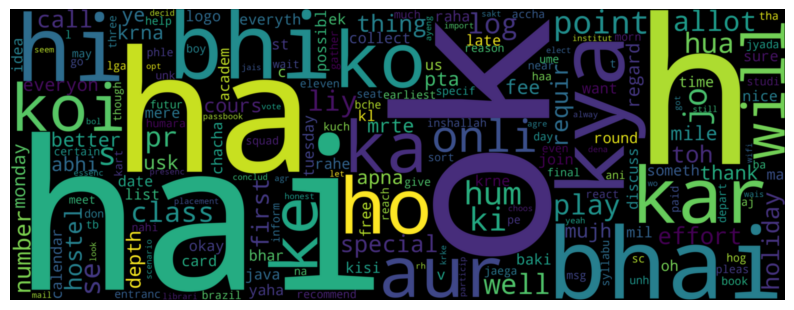

In [ ]:
# Size of the image generated
plt.figure(figsize=(10,20))

plt.imshow(wc,interpolation="gaussian")

plt.axis('off')
plt.show()

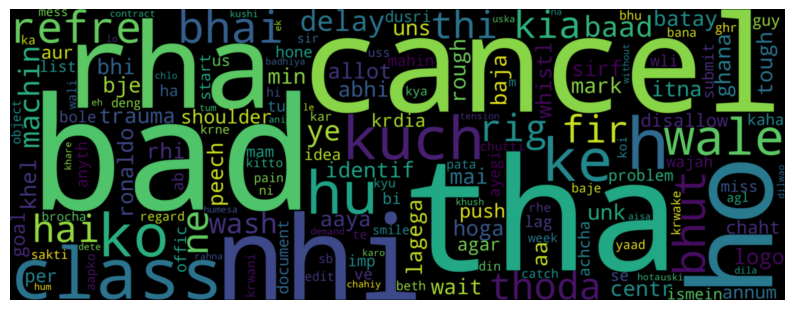

In [ ]:
wc = WordCloud(background_color='black', height=1500, width=4000).generate(all_words_negative)
plt.figure(figsize=(10,20))
plt.imshow(wc,interpolation="gaussian")
plt.axis('off')
plt.show()

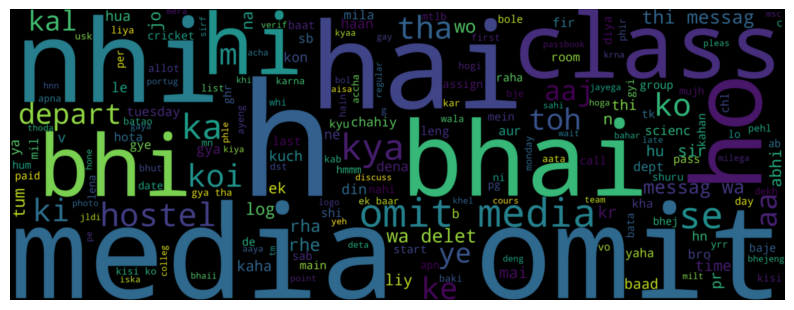

In [ ]:
wc = WordCloud(background_color='black', height=1500, width=4000).generate(all_words_neutral)
plt.figure(figsize=(10,20))
plt.imshow(wc,interpolation="gaussian")
plt.axis('off')
plt.show()

In [ ]:
# Feature Extraction
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(data['Translated_Message'])
y = data['compound_score'] > 0

In [ ]:
# Train multiple machine learning models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(kernel='linear', random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42)
}

In [ ]:
# Evaluate each model
results = {}
for name, model in models.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [ ]:
pip install langdetect

In [ ]:
# Real-time Sentiment Prediction Function

def predict_sentiment(message):
    translate_message(message)
    preprocessed_message = preprocess_text(message)
    features = tfidf_vectorizer.transform([preprocessed_message])
    sentiment_prediction = sia.polarity_scores(message)['compound']
    return 'positive' if sentiment_prediction > 0 else 'negative' if sentiment_prediction < 0 else 'neutral'

In [ ]:
# Example usage:
new_message = "something feels off lately"
real_time_sentiment = predict_sentiment(new_message)
print("Real-time Sentiment Prediction:", real_time_sentiment)

Real-time Sentiment Prediction: neutral


In [ ]:
print("Accuracy of Machine Learning Models:")
for name, accuracy in results.items():
    print(f"{name}: {accuracy}")

Accuracy of Machine Learning Models:
Random Forest: 0.95
Support Vector Machine: 0.945
Logistic Regression: 0.92


In [ ]:
nltk.download('punkt')